# Задание для Курсовой работы

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. 
В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. 
После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты. 
На то, как система будет реагировать на определенные жесты - выбор за вами. 
Например, на определенный жест (жест пис), система будет здороваться с человеком. 
На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет для жестов рук. 
Возможные датасеты:

https://www.kaggle.com/gti-upm/leapgestrecog

https://lttm.dei.unipd.it/downloads/gesture/

https://www.kaggle.com/datamunge/sign-language-mnist

https://www.kaggle.com/roobansappani/hand-gesture-recognition 

На основании выбранного датасета нужно разработать модель для обучения и обучить эту модель.


In [1]:
import os
import torch
import torchvision
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
#%matplotlib inline
import time
from torch.autograd import Variable
import seaborn
import cv2
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from facenet_pytorch import MTCNN
from PIL import Image

# 1. Обзор данных

Для проекта используется датасет 
https://www.kaggle.com/datamunge/sign-language-mnist

In [2]:
mnist_train = pd.read_csv("./sign-language-mnist/data/sign_mnist_train.csv")
mnist_test = pd.read_csv("./sign-language-mnist/data/sign_mnist_test.csv")

In [3]:
print(mnist_train.shape, mnist_test.shape)

(27455, 785) (7172, 785)


In [4]:
mnist_train.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149


In [5]:
#количество лейблов в трейне и тесте
mnist_train['label'].nunique()

24

In [6]:
mnist_test['label'].nunique()

24

In [7]:
mnist_train['label'].unique()

array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14], dtype=int64)

In [8]:
#Проверим, есть ли пропуски
print(mnist_train.isna().any().any(), mnist_test.isna().any().any())

False False


In [9]:
mnist_train_data = mnist_train.loc[:, "pixel1":]
mnist_train_label = mnist_train.loc[:, "label"]

mnist_test_data = mnist_test.loc[:, "pixel1":]
mnist_test_label = mnist_test.loc[:, "label"]

In [10]:
# Data Normalization
mnist_train_data = mnist_train_data/255.0
mnist_test_data = mnist_test_data/255.0

IMAGE LABEL: 22


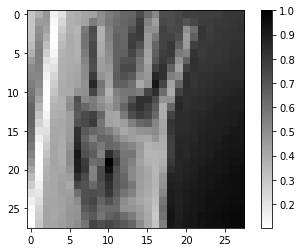

In [11]:
# пример изображения
data_array = np.array(mnist_train_data.loc[13, :])
shaped_data = np.reshape(data_array, (28, 28))
sign_img = plt.imshow(shaped_data, cmap=plt.cm.binary)
plt.colorbar(sign_img)
print("IMAGE LABEL: {}".format(mnist_train.loc[13, "label"]))
plt.show()

# 2. Подготовка данных

In [12]:
test_data_raw = pd.read_csv('./sign-language-mnist/data/sign_mnist_test.csv')
data_raw = pd.read_csv('./sign-language-mnist/data/sign_mnist_train.csv')

In [13]:
labels = data_raw['label']
data_raw.drop('label', axis=1, inplace=True)
labels_test = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True)

data = data_raw.values
labels = labels.values
test_data = test_data_raw.values
labels_test = labels_test.values

In [14]:
def reshape_to_2d(data, dim):
    reshaped = []
    for i in data:
        reshaped.append(i.reshape(1, dim, dim))

    return np.array(reshaped)

In [15]:
data = reshape_to_2d(data, 28)

x = torch.FloatTensor(data)
y = torch.LongTensor(labels.tolist())

test_labels = torch.LongTensor(labels_test.tolist())

test_data_formated = reshape_to_2d(test_data, 28)
test_data_formated = torch.FloatTensor(test_data_formated)

# 3. Модель для распознавания жестов

In [27]:
epochs = 50
batch_size = 100
learning_rate = 0.001

In [28]:
class Network(nn.Module): 
    
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(20, 30, 3) 
        self.dropout1 = nn.Dropout2d()
        
        self.fc3 = nn.Linear(30 * 3 * 3, 270) 
        self.fc4 = nn.Linear(270, 26) 
        
        self.softmax = nn.LogSoftmax(dim=1)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)
                
        x = x.view(-1, 30 * 3 * 3) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return self.softmax(x)
    
    
    def test(self, predictions, labels):
        
        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))
        
    
    def evaluate(self, predictions, labels):
                
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        return(acc)

In [29]:
net = Network()
print(net)

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=270, out_features=270, bias=True)
  (fc4): Linear(in_features=270, out_features=26, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [30]:
optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0.7)
loss_func = nn.CrossEntropyLoss()

In [31]:
loss_log = []
acc_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size] 
        y_mini = y[i:i + batch_size] 
        
        optimizer.zero_grad()
        net_out = net(Variable(x_mini))
        
        loss = loss_func(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(net.evaluate(torch.max(net(Variable(test_data_formated[:500])).data, 1)[1], 
                                        test_labels[:500]))
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 2.889609
Epoch: 2 - Loss: 2.074055
Epoch: 3 - Loss: 1.735752
Epoch: 4 - Loss: 1.289359
Epoch: 5 - Loss: 0.994310
Epoch: 6 - Loss: 0.936245
Epoch: 7 - Loss: 0.706467
Epoch: 8 - Loss: 0.364471
Epoch: 9 - Loss: 0.510432
Epoch: 10 - Loss: 0.284775
Epoch: 11 - Loss: 0.273558
Epoch: 12 - Loss: 0.166152
Epoch: 13 - Loss: 0.365644
Epoch: 14 - Loss: 0.222069
Epoch: 15 - Loss: 0.321834
Epoch: 16 - Loss: 0.106737
Epoch: 17 - Loss: 0.141404
Epoch: 18 - Loss: 0.113599
Epoch: 19 - Loss: 0.142250
Epoch: 20 - Loss: 0.161216
Epoch: 21 - Loss: 0.136303
Epoch: 22 - Loss: 0.178103
Epoch: 23 - Loss: 0.216880
Epoch: 24 - Loss: 0.216781
Epoch: 25 - Loss: 0.179307
Epoch: 26 - Loss: 0.043556
Epoch: 27 - Loss: 0.120365
Epoch: 28 - Loss: 0.038613
Epoch: 29 - Loss: 0.214100
Epoch: 30 - Loss: 0.070138
Epoch: 31 - Loss: 0.118903
Epoch: 32 - Loss: 0.105135
Epoch: 33 - Loss: 0.052352
Epoch: 34 - Loss: 0.151241
Epoch: 35 - Loss: 0.020102
Epoch: 36 - Loss: 0.009016
Epoch: 37 - Loss: 0.020125
Epoch: 38 

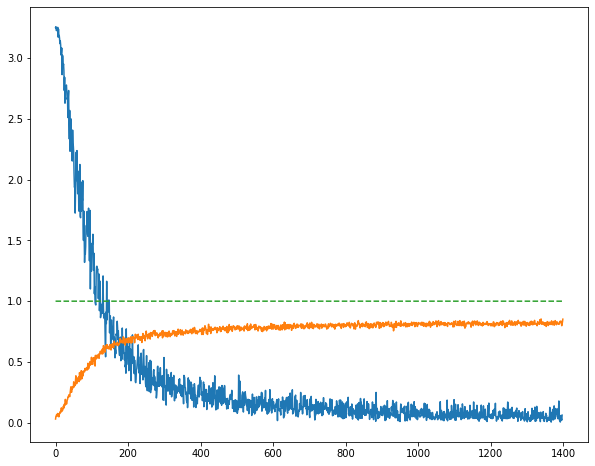

In [32]:
#Построим график loss function(синий график) и accuracy(оранжевый)
import matplotlib.pyplot as plt


plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)), linestyle='dashed')

In [33]:
alph = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

Prediction: H
Actual Label: H
Prediction: I
Actual Label: I
Prediction: I
Actual Label: I
Prediction: V
Actual Label: V


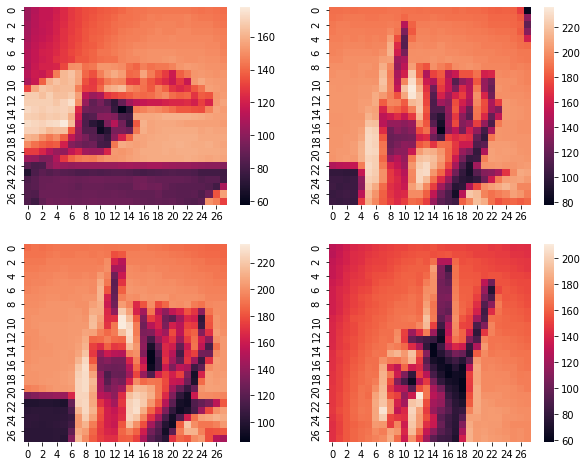

In [34]:
plt.figure(figsize=(10, 8))

sample = 30
pixels = test_data[sample].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 42
pixels = test_data[sample].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 100
pixels = test_data[sample].reshape(28, 28)
plt.subplot(223)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 22
pixels = test_data[sample].reshape(28, 28)
plt.subplot(224)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

In [35]:
# посмотрим количество правильно классифицированных картинок
predictions = net(Variable(test_data_formated))
net.test(torch.max(predictions.data, 1)[1], test_labels)

Correct predictions:  6026 /  7172 (0.840212)


In [36]:
#сохраним модель
torch.save(net.state_dict(), './model_sign.pth')

In [37]:
#загрузим модель
net = Network()
net.load_state_dict(torch.load('./model_sign.pth'))
net.eval()

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=270, out_features=270, bias=True)
  (fc4): Linear(in_features=270, out_features=26, bias=True)
  (softmax): LogSoftmax(dim=1)
)

# 4. Прототип приложения для определения жестов человека перед веб-камерой

In [38]:
index_to_letter = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [58]:
# Класс детектирования и обработки лица с веб-камеры 
class FaceDetector(object):

    def __init__(self, mtcnn, net,channels=1):
        # Создаем объект для считывания потока с веб-камеры или видео
        self.cap = cv2.VideoCapture('./IMG_3129.MOV') 
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = net
        self.channels = channels

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs):
        try:
            for box, prob in zip(boxes, probs):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), thickness=2)

        except Exception as e:
            print('Something wrong im draw function!')
            print(f'error : {e}')
        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]-40):int(box[3]+40), 
                int(box[0]-40):int(box[2]+40)])
        return faces
    # Функция для вырезания жеста с кадра
    @staticmethod
    def center_crop(frame):
        h, w, _ = frame.shape
        start = abs(h - w) // 2
        if h > w:
            return frame[start: start + w]
        return frame[:, start: start + h]
    
       
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        continue_cycle = True
        while continue_cycle:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = self.cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                
                boxes, probs = self.mtcnn.detect(frame, landmarks=False)
                
                
                self._draw(frame, boxes, probs)
                # Меняем значение переменной продолжение цикла - нет, так как лицо мы нашли и дальше будет распознавание жестов
                continue_cycle = False

            except Exception as e:
                print('Something wrong im main cycle!')
                print(f'error : {e}')

            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2.imshow('Face Detection', frame)
            
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        l = ' '
        while True:
            
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = self.cap.read()
            if ret == False:
                break
            try:
                # Capture frame-by-frame
                frame = self.center_crop(frame)
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                x = cv2.resize(frame, (28, 28))
                x = torch.FloatTensor(x.reshape(1, 1, 28, 28).astype(np.float32))
                y = self.emodel(x)
                index = torch.max(y.data, 1)[1].numpy()[0]
                letter = index_to_letter[int(index)]
                if l[-1]!=letter:
                    l+=letter
                #cv2.putText(frame, letter, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 255, 0), thickness=2)
                #cv2.imshow("Sign Language Translator", frame)

            except Exception as e:
                print('Something wrong im main cycle!')
                print(f'error : {e}')
            
            cv2.putText(frame, letter, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 255, 0), thickness=2)
            cv2.imshow("Sign Language Translator", frame)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
                

                
        # Очищаем все объекты opencv, что мы создали
        self.cap.release()
        cv2.destroyAllWindows()
        return l
    

In [59]:
# Загружаем мтцнн
mtcnn = MTCNN()

# Создаем объект нашего класса приложения
fcd = FaceDetector(mtcnn, net)
# Запускаем
result = fcd.run()

In [60]:
# по результатам работы приложения имеем строку с определнными буквами
result

' BRQSPXFXLXIHIMAMNMSMNYANYNYAYANANAYAYAYANANBTGLKGTGTMNMNMTMNTMGTGTMTGTMTGTGMGTMGTKTHTHYHYTHGMYLYPYPLPLILIXIHIHLPXPYLYHYHYLYFTFTCTHTHTATIAITWTIHIAHTITITMNMTYTITITITXITXT'